This script implements an Extended Kalman Filter (EKF) to estimate the user's position 
based on pseudorange data from 8 base stations.
Following professor's notes for EKF implementation.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modules.calculate_LSM import calculate_LSM

In [46]:
# Load data
P = pd.read_csv("pseudoranges.csv").to_numpy()
base_stations = pd.read_csv("base_stations_LC.csv").to_numpy()

In [73]:
# Constants
c = 299792458.0  # Speed of light in m/s
dt = 1.0  # Time step in seconds (used in the transition matrix T)
sigma_dt = 0.5e-9  # Clock drift standard deviation (0.5 ns)
sigma_pos = 1.0  # Position process noise standard deviation (Assuming 1 meter)
sigma_vel = 0.1  # Velocity process noise standard deviation (Assuming 0.1 m/s)
sigma_pseudorange = 1  # Pseudorange measurement noise standard deviation (Assuming 1 meter)

In [74]:
# Number of base stations and measurements
n_stations = base_stations.shape[0]
n_measurements = P.shape[0]

print(f"Number of base stations: {n_stations}")
print(f"Number of measurements: {n_measurements}")
print(f"Base stations shape: {base_stations.shape}")
print(f"Pseudoranges shape: {P.shape}")

Number of base stations: 8
Number of measurements: 270
Base stations shape: (8, 3)
Pseudoranges shape: (270, 8)


State vector: [N_u, E_u, V_N, V_E, c*dt_u]

N_u, E_u: North and East positions

V_N, V_E: North and East velocities  

c*dt_u: Clock offset (in meters)

**Initialization**

In [75]:
# Initialize state vector
# Starting guess: LSM of 1st point
initial_E, initial_N, _, _ = calculate_LSM(P[:1], base_stations)[0]
initial_VN, initial_VE, initial_clock_offset = 0.0, 0.0, 0.0  # Assuming initial velocities are zero

x_hat = np.array([initial_N, initial_E, initial_VN, initial_VE, initial_clock_offset])
print(f"Initial state estimate: {x_hat}")

Initial state estimate: [29.81347991 99.85669789  0.          0.          0.        ]


**State transition model**

In [76]:
# State transition matrix T_k (constant velocity model)
T = np.array([
    [1, 0, dt, 0, 0],  # N_u(k) = N_u(k-1) + dt * V_N(k-1)
    [0, 1, 0, dt, 0],  # E_u(k) = E_u(k-1) + dt * V_E(k-1)
    [0, 0, 1, 0, 0],   # V_N(k) = V_N(k-1)
    [0, 0, 0, 1, 0],   # V_E(k) = V_E(k-1)
    [0, 0, 0, 0, 1]    # c*dt_u(k) = c*dt_u(k-1)
])

# Process noise covariance matrix C_k^model
C_model = np.diag([
    sigma_pos**2,  # Position N noise
    sigma_pos**2,  # Position E noise
    sigma_vel**2,  # Velocity N noise
    sigma_vel**2,  # Velocity E noise
    (c * sigma_dt)**2  # Clock offset noise
])

# Initial error covariance matrix
C_error = np.eye(5) * 10.0**2  # Large initial uncertainty

# Measurement noise covariance matrix C_k^obs
C_obs = np.eye(n_stations) * sigma_pseudorange**2

In [77]:
def compute_predicted_pseudoranges(state, base_stations):
    """
    Compute predicted pseudoranges based on current state estimate.
    rho_k^i = sqrt((N^i-N_u)^2 + (E^i-E_u)^2 + (U^i-U_u)^2) + c*dt_u
    """
    N_u, E_u, _, _, clock_offset = state
    U_u = 0.0  # Assuming user is at ground level (#TODO)
    
    predicted_ranges = np.zeros(n_stations)
    
    for i in range(n_stations):
        E_i, N_i, U_i = base_stations[i]
        
        # Geometric range
        geometric_range = np.sqrt((N_i - N_u)**2 + (E_i - E_u)**2 + (U_i - U_u)**2)
        
        # Add clock offset
        predicted_ranges[i] = geometric_range + clock_offset
    
    return predicted_ranges

In [78]:
def compute_jacobian_A(state, base_stations):
    """
    Compute Jacobian matrix A_k (partial derivatives of measurement function)
    A is (n_stations x 5) matrix
    """
    N_u, E_u, _, _, _ = state
    U_u = 0.0  # Assuming user is at ground level
    
    A = np.zeros((n_stations, 5))
    
    for i in range(n_stations):
        E_i, N_i, U_i = base_stations[i]
        
        # Geometric range
        range_i = np.sqrt((N_i - N_u)**2 + (E_i - E_u)**2 + (U_i - U_u)**2)
        
        # Partial derivatives
        if range_i > 1e-10:  # Avoid division by zero
            # ∂ρ/∂N_u = -(N_i - N_u) / range_i
            A[i, 0] = -(N_i - N_u) / range_i  # e_N
            # ∂ρ/∂E_u = -(E_i - E_u) / range_i  
            A[i, 1] = -(E_i - E_u) / range_i  # e_E
            # ∂ρ/∂V_N = 0
            A[i, 2] = 0.0
            # ∂ρ/∂V_E = 0
            A[i, 3] = 0.0
            # ∂ρ/∂(c*dt_u) = 1
            A[i, 4] = 1.0
    
    return A

In [79]:
# Storage for results
estimated_states = np.zeros((n_measurements, 5))
covariances = np.zeros((n_measurements, 5, 5))

**EKF Main Loop**

In [80]:

for k in range(n_measurements):
    # Current measurements
    y_k = P[k, :]
    
    # PREDICTION STEP
    # Predict state: x̂(k|k-1) = T_k * x̂(k-1|k-1)
    if k == 0:
        x_hat_pred = x_hat  # Use initial state for first measurement
    else:
        x_hat_pred = T @ x_hat

    # Predict covariance: K_k = C_k^model + T_k * C_(k-1)^e * T_k^T
    K_pred = C_model + T @ C_error @ T.T
    
    # UPDATE STEP
    # Compute predicted measurements
    f_k = compute_predicted_pseudoranges(x_hat_pred, base_stations)
    
    # Innovation: ξ_k = y_k - f_k(x̂(k|k-1))
    xi_k = y_k - f_k
    
    # Compute Jacobian matrix A_k
    A_k = compute_jacobian_A(x_hat_pred, base_stations)

    # Kalman gain: G_k = K_k * A_k^T * [C_k^obs + A_k * K_k * A_k^T]^(-1)
    S_k = C_obs + A_k @ K_pred @ A_k.T  # Innovation covariance
    G_k = K_pred @ A_k.T @ np.linalg.inv(S_k)
    
    # ESTIMATE STEP
    # Updated state estimate: x̂(k|k) = x̂(k|k-1) + G_k * ξ_k
    x_hat = x_hat_pred + G_k @ xi_k
    
    # Updated covariance: C_k^e = (I - G_k * A_k) * K_k
    I = np.eye(5)
    C_error = (I - G_k @ A_k) @ K_pred
    
    # Store results
    estimated_states[k] = x_hat
    covariances[k] = C_error

In [81]:
estimated_states[:, [0, 1]] = estimated_states[:, [1, 0]]  # N <-> E
# Extract results for plotting
positions_E = estimated_states[:, 0]
positions_N = estimated_states[:, 1]
velocities_N = estimated_states[:, 2]
velocities_E = estimated_states[:, 3]
clock_offset = estimated_states[:, 4]

Create plots

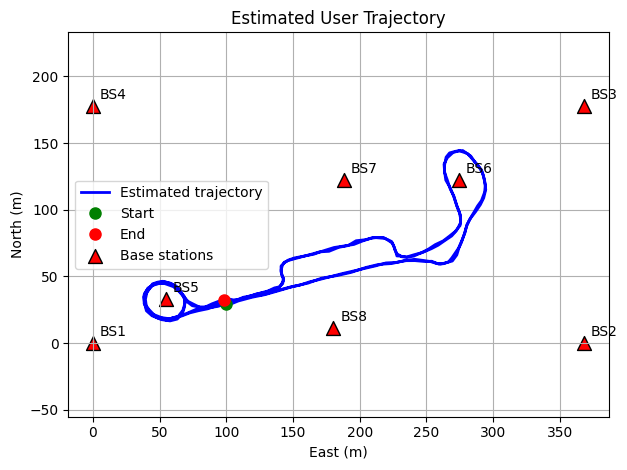

In [82]:
# Plot trajectory
plt.plot(positions_E, positions_N, 'b-', linewidth=2, label='Estimated trajectory')
plt.plot(positions_E[0], positions_N[0], 'go', markersize=8, label='Start')
plt.plot(positions_E[-1], positions_N[-1], 'ro', markersize=8, label='End')

# Plot base stations
plt.scatter(base_stations[:, 0], base_stations[:, 1], c='red', s=100, marker='^', 
           label='Base stations', edgecolors='black')
for i, (E, N, U) in enumerate(base_stations):
    plt.annotate(f'BS{i+1}', (E, N), xytext=(5, 5), textcoords='offset points')

plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Estimated User Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [83]:
# Extract position uncertainties (standard deviations)
std_N = np.sqrt(covariances[:, 0, 0])
std_E = np.sqrt(covariances[:, 1, 1])

# Print final results
print(f"\nFinal Results:")
print(f"Final position: N = {positions_N[-1]:.2f} m, E = {positions_E[-1]:.2f} m")
print(f"Final velocity: VN = {velocities_N[-1]:.3f} m/s, VE = {velocities_E[-1]:.3f} m/s")
print(f"Final clock offset: {clock_offset[-1]:.2f} m")
print(f"Final position uncertainties: σN = {std_N[-1]:.2f} m, σE = {std_E[-1]:.2f} m")


Final Results:
Final position: N = 32.03 m, E = 98.32 m
Final velocity: VN = 0.252 m/s, VE = 2.903 m/s
Final clock offset: 299.37 m
Final position uncertainties: σN = 0.69 m, σE = 0.40 m


In [84]:
# Calculate and print some statistics
total_distance = np.sum(np.sqrt(np.diff(positions_E)**2 + np.diff(positions_N)**2))
avg_speed = np.mean(np.sqrt(velocities_N**2 + velocities_E**2))

print(f"\nTrajectory Statistics:")
print(f"Total distance traveled: {total_distance:.2f} m")
print(f"Average speed: {avg_speed:.3f} m/s")


Trajectory Statistics:
Total distance traveled: 1579.41 m
Average speed: 3.739 m/s


In [85]:
# Save results to CSV
results_df = pd.DataFrame(estimated_states, columns=['E', 'N', 'VN', 'VE', 'ClockOffset'])
results_df.to_csv("ex_kalman_LC.csv", index=False)